In [6]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torchvision import models
from torchvision import transforms, utils
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image, ImageFilter, ImageChops

### Functions and Globals

In [7]:
normalise = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
    )

preprocess = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    normalise
    ])

def load_image(path):
    image = Image.open(path)
    plt.imshow(image)
    return image

def un_normalize(image):
    return image * torch.Tensor([0.229, 0.224, 0.225])  + torch.Tensor([0.485, 0.456, 0.406])

def dream_forward_pass(image, layer, iterations, lr):        
    '''
    image - input image to pass forward through VGG-16
    layer - which layer to stop the forward pass
    iterations - how many times to iterate through the network
    lr - learning rate
    '''
    
    ### preprocess transforms image to a 224x224 tensor
    ### unsqueeze transforms 224x224 -> 1X224x224
    input = Variable(preprocess(image).unsqueeze(0), requires_grad=True)
    
    ### zero out the gradient 
    vgg.zero_grad()
    
    for i in range(iterations):
        output = input
        ### loop through the layer and update the output
        for j in range(layer):
            output = modulelist[j+1](output)
        
        ### calculate loss (normalize, backprop, learning rate)
        loss = output.norm()
        loss.backward()
        input.data = input.data + lr * input.grad.data
    
    ### squeeze removes the 1's from the shape i.e 1x224x224 -> 224x224
    input = input.data.squeeze()
    input.transpose_(0,1)
    input.transpose_(1,2)
    
    ### un normalize the input and clip numbers to be between 0 and 1
    input = np.clip(un_normalize(input), 0, 1)
    img = Image.fromarray(np.uint8(input*255))
    return img

def deep_dream_vgg(image, layer, iterations, lr, octave_scale, num_octaves):
    '''
    Purpose: Recursively downsize the image by num_octaves and octave_scale, call 
             forward pass to pass the image through the model, then upscale the
             image and blends it with one level higher in the recursion tree.
    
    Parameters: image - image to be passed through model
                layer - what layer to stop passing forward
                iterations - how many times to pass the image through the model
                lr - learning rate for updating data with gradient data
                octave_scale - scale for downsizing image
                num_octaves - number of times to downsize image
    '''
    ###Recursive call
    if num_octaves>0:
        ### Reduce image noise using GaussianBlur Radius = 2
        image1 = image.filter(ImageFilter.GaussianBlur(2))
        
        ### Prevent the image from downscaling to far
        if(image1.size[0]/octave_scale < 1 or image1.size[1]/octave_scale<1):
            size = image1.size
        else:
            size = (int(image1.size[0]/octave_scale), int(image1.size[1]/octave_scale))
        
        ### Downsize image
        image1 = image1.resize(size,Image.ANTIALIAS)
        
        ### Pass downsized image into recursively into function
        image1 = deep_dream_vgg(image1, layer, iterations, lr, octave_scale, num_octaves-1)
        
        ### Get new size
        size = (image.size[0], image.size[1])
        
        ### Resize the image
        image1 = image1.resize(size,Image.ANTIALIAS)
        
        ### blend image with the image one level higher
        image = ImageChops.blend(image, image1, 0.6)
    
    ### forward pass and resize image
    img_result = dream_forward_pass(image, layer, iterations, lr)
    img_result = img_result.resize(image.size)
    
    ### Show image
    plt.imshow(img_result)
    plt.axis('off')
    return img_result

### VGG-16

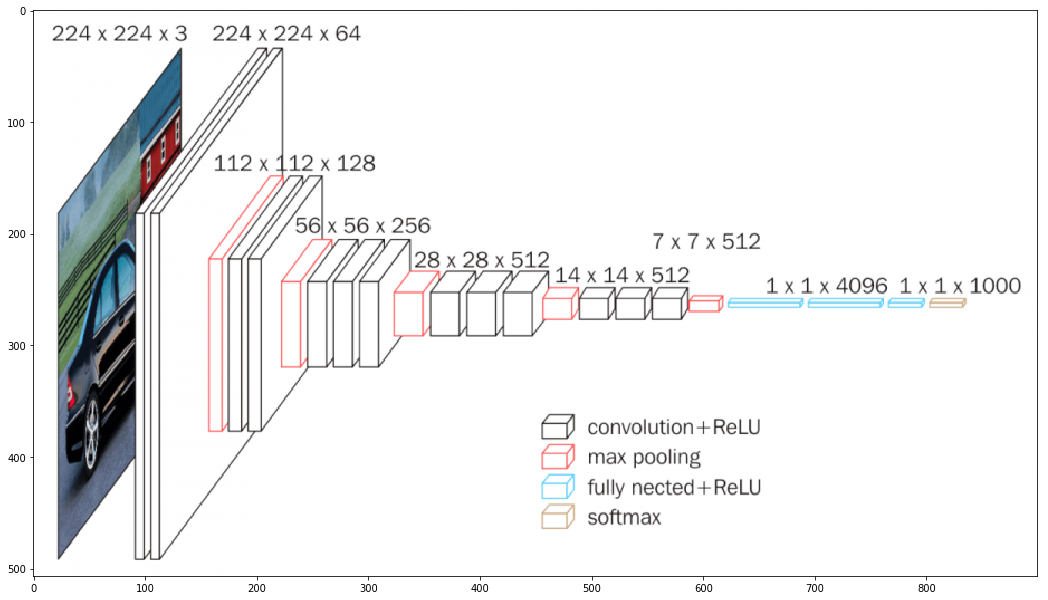

In [8]:
image = Image.open('Images/VGG16_arch.png')
plt.figure(figsize=(18,15))
plt.imshow(image)

In [9]:
vgg = models.vgg16(pretrained=True)         ### load the pretrained model
print(vgg)
modulelist = list(vgg.features.modules())   ### Save each layer into a list for easy access to each layer

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

### Political Figures 

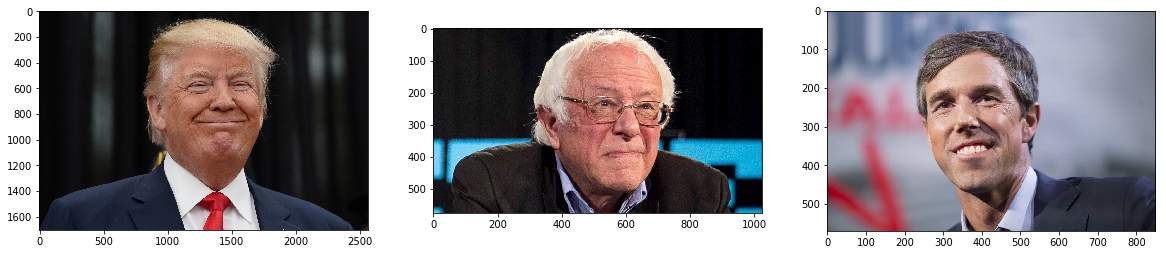

In [92]:
input_images = ['Images/trump.jpg', 'Images/sanders.jpg', 'Images/beto.jpg']

fig = plt.figure(figsize=(20,10))
for i in range(3):
    plt.subplot(1, 3, i+1)
    img = load_image(input_images[i])

### Deep Dream with Layers Blended

Currently on Image #0
Currently on Image #1
Currently on Image #2


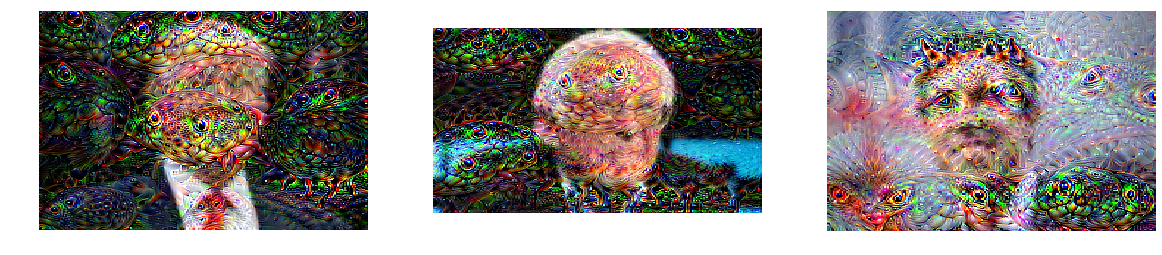

In [89]:
layer_number = 28
iterations = 20
lr = 2e-2
octave_scale = 1.4
num_octaves = 20


fig = plt.figure(figsize=(20,10))
for i in range(3):
    print ("Currently on Image #{}".format(i))
    plt.subplot(1, 3, i+1)
    img = Image.open(input_images[i])
    img = deep_dream_vgg(img, layer_number, iterations, lr, octave_scale, num_octaves)
    plt.imshow(img)

### Deep Dream Final Layer Only

Currently on Image #0
Currently on Image #1
Currently on Image #2


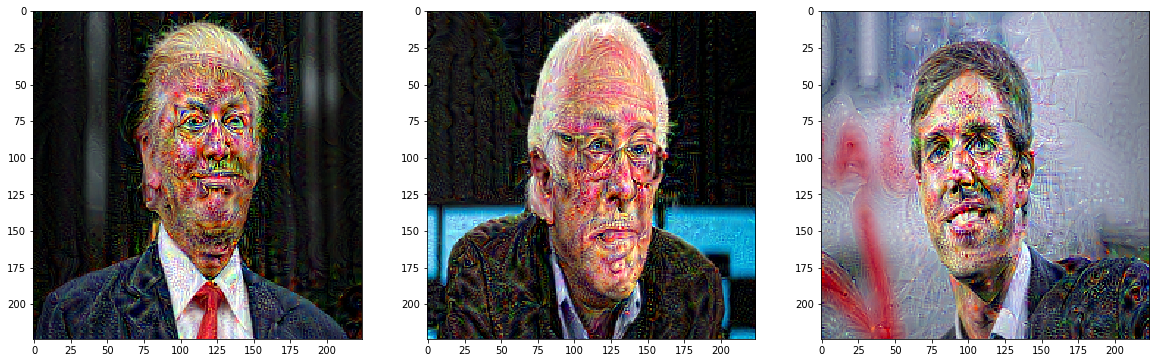

In [93]:
fig = plt.figure(figsize=(20,10))
for i in range(3):
    print ("Currently on Image #{}".format(i))
    plt.subplot(1, 3, i+1)
    img = Image.open(input_images[i])
    img = dream_forward_pass(img, layer_number, iterations, lr)
    plt.imshow(img)

### Nature

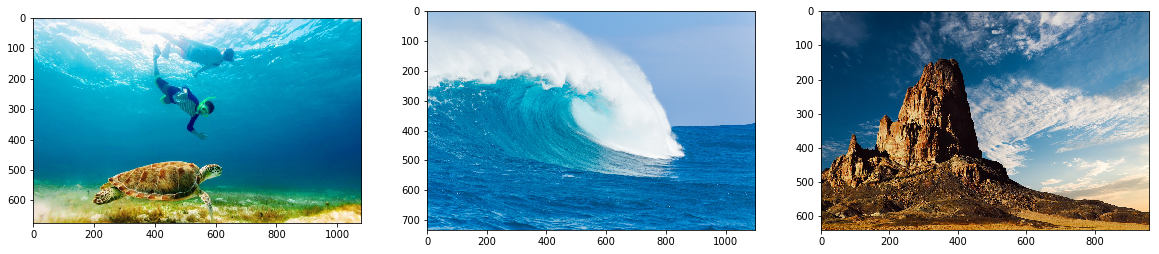

In [4]:
input_images = ['Images/underwater_turtle.jpg', 'Images/waves.jpg', 'Images/mountain.jpg']

fig = plt.figure(figsize=(20,10))
for i in range(3):
    plt.subplot(1, 3, i+1)
    img = load_image(input_images[i])

### Deep Dream with Layers Blended

Currently on Image #0
Currently on Image #1
Currently on Image #2


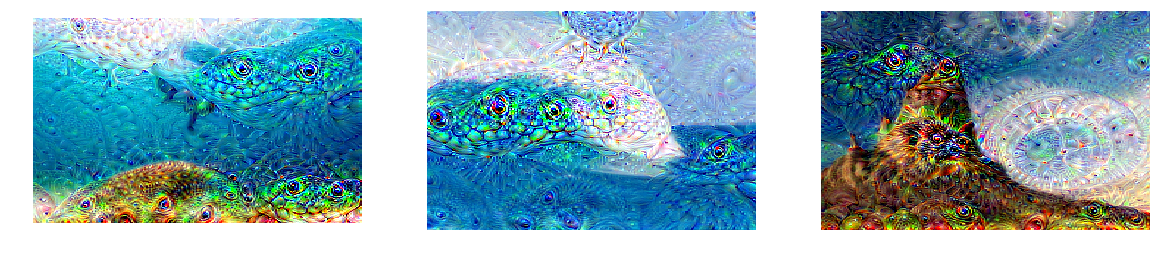

In [91]:
layer_number = 28
iterations = 20
lr = 2e-2
octave_scale = 2
num_octaves = 20


fig = plt.figure(figsize=(20,10))
for i in range(3):
    print ("Currently on Image #{}".format(i))
    plt.subplot(1, 3, i+1)
    img = Image.open(input_images[i])
    img = deep_dream_vgg(img, layer_number, iterations, lr, octave_scale, num_octaves)
    plt.imshow(img)

### Deep Dream Final Layer Only

Currently on Image #0
Currently on Image #1
Currently on Image #2


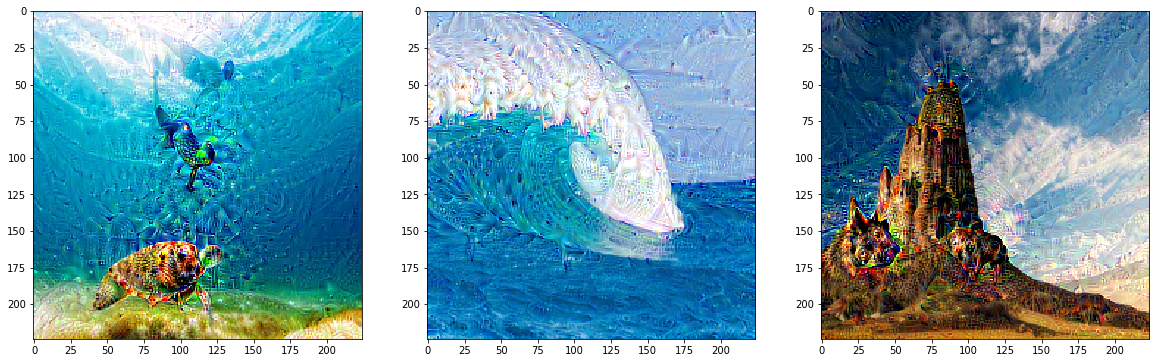

In [95]:
fig = plt.figure(figsize=(20,10))
for i in range(3):
    print ("Currently on Image #{}".format(i))
    plt.subplot(1, 3, i+1)
    img = Image.open(input_images[i])
    img = dream_forward_pass(img, layer_number, iterations, lr)
    plt.imshow(img)

### First 10 Layers of VGG-16

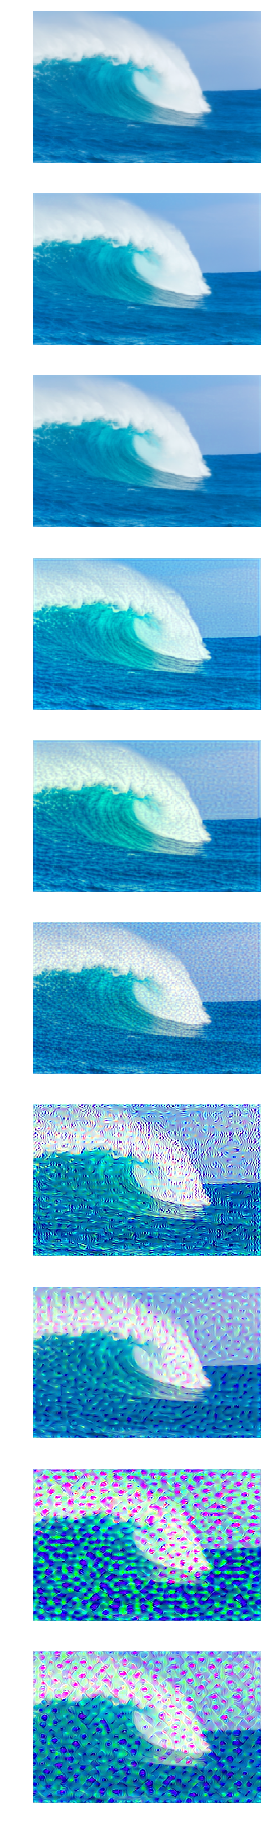

In [105]:
fig

### All Layers of VGG-16


In [ ]:
iterations = 20
lr = 2e-2
octave_scale = 2
num_octaves = 20
count = 1

fig2 = plt.figure(figsize=(200,1000))
for i in range(30):
    print ("Currently on Layer {}".format(i))
    fig2.add_subplot(30, 1, count)
    img = Image.open(input_images[1])
    img = deep_dream_vgg(img, i, iterations, lr, octave_scale, num_octaves)
    plt.imshow(img)
    count += 1

In [11]:
fig2.savefig('fig2.pdf')

In [14]:
fig2.tight_layout()
fig2.savefig('fig2.pdf')